In [1]:
import logging
import io

from IPython.display import display, clear_output
from PIL import Image
file_object = io.BytesIO() # 'view.jpg' #
import cv2
import numpy as np

!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

from IPython.display import Audio

from aiohttp import web
routes = web.RouteTableDef()
app = web.Application(client_max_size=4096000)
logging.basicConfig(level=logging.DEBUG)

In [2]:
net = cv2.dnn.readNet('yolov3.cfg', 'yolov3.weights')

layer_names = net.getLayerNames()
out_layers_indexes = net.getUnconnectedOutLayers()
out_layers = [layer_names[index[0] - 1] for index in out_layers_indexes]

with open('coco.names.txt') as f:
    classes = f.read().split('\n')

In [3]:
def apply_yolo(img, draw_object_=True):
    '''get: array-like img data 
    return: img with wrawed object boxes & boxes'''
    height,width,depth = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255, (608,608), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    
    outs = net.forward(out_layers)
    
    boxes = []
    class_indexes = []
    class_scores = []

    for out in outs:
        for obj in out:
            #print(obj)
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            if class_score > 0: 
                #print(class_index, class_score)
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)

                x = center_x - obj_width // 2
                y = center_y - obj_height // 2

                box = [x,y,obj_width,obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))
                
    object_box_list = cv2.dnn.NMSBoxes(boxes, class_scores, 0, 0.35)
    #print(chosen_boxes)
    
    xywh_name_class_list = []    
    for box_index in object_box_list:
        box_index = box_index[0]
        xywh_name_class_list.append([boxes[box_index] + [classes[class_indexes[box_index]]] + [class_indexes[box_index]]])
        # TODO uncomment 2 debug
        img = draw_object(img, class_indexes[box_index], class_scores[box_index], boxes[box_index])
        
    return img, xywh_name_class_list


In [4]:
def draw_object(img, index, score, box):
    x,y,w,h = box
    start = (x,y)
    end = (x + w, y + h)
    color = (0,255,0)
    width = 1
    
    img = cv2.rectangle(img, start, end, color, width)
    
    start = (x-10, y-10)
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 1
    text = classes[index]
    
    img = cv2.putText(img, text, start, font, font_size, color, width, cv2.LINE_AA)
#     font = ImageFont.truetype('segoeuil.ttf', size=18)
#     img = ImageDraw.Draw(img)
#     img.text(
#         start,
#         text,
#         # Добавляем шрифт к изображению
#         font=font,
#         fill='#00FF00')
    
    return img

In [5]:
@routes.post('/get_objects')
async def get_objects(request=None):  
    print('getting objects from body')
    file_object = await request.read()
#     try:
    img = Image.frombytes('RGB', (1280, 720), file_object).rotate(180) 
#     except: 
#         img = Image.open(io.BytesIO(file_object)).rotate(180) # 
    arr = np.array(img)
    arr, xywh_name_class_list = apply_yolo(arr)
    img = Image.fromarray(arr)
    app['img'] = img
    clear_output()
    display(app['img'])
    
    if len(xywh_name_class_list) > 0: 
        Audio('1.ogg', autoplay=True)
    
    return web.Response(text=str(xywh_name_class_list))

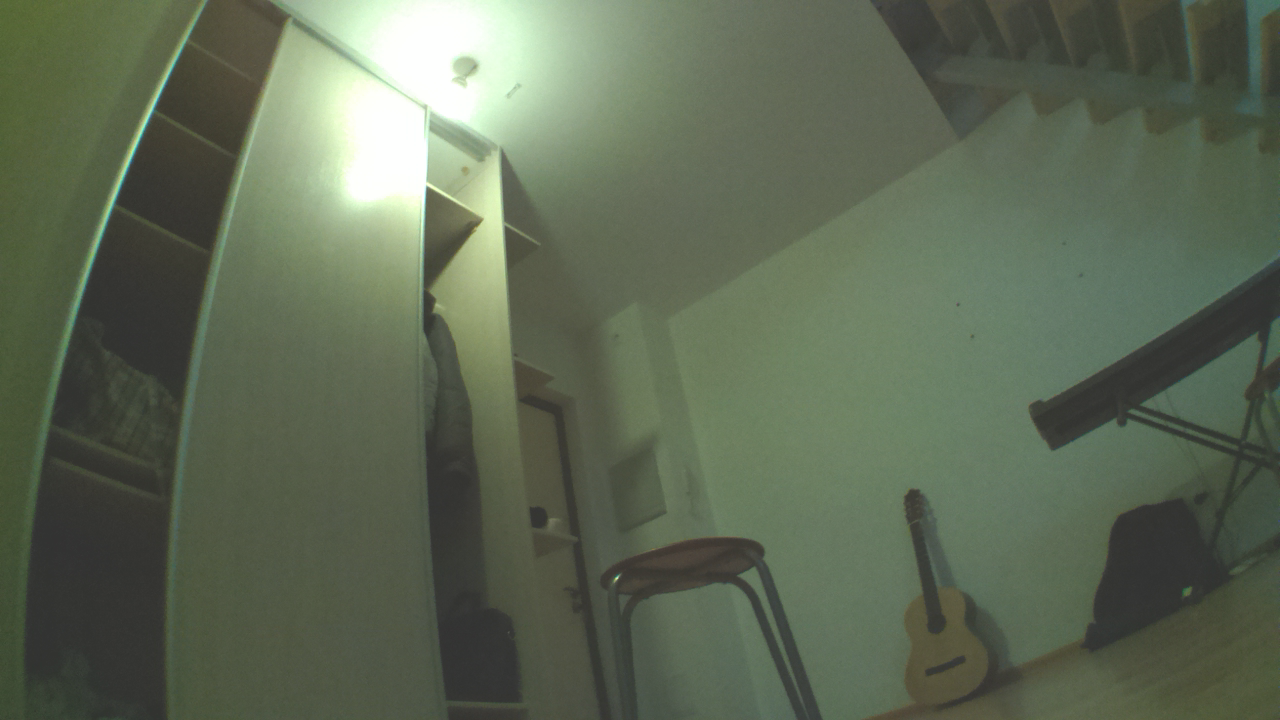

INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:18 +0000] "POST /get_objects HTTP/1.1" 200 152 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:25 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:30 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:38 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:46 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:17:54 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:18:03 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:18:12 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


getting objects from body


INFO:aiohttp.access:192.168.0.104 [12/Feb/2022:16:18:23 +0000] "POST /get_objects HTTP/1.1" 413 241 "-" "python-requests/2.25.1"


In [ ]:
if __name__ == '__main__':
    app['img']=None
    app.add_routes(routes)
    web.run_app(app)

In [ ]:
app['img'].show()